## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
from PIL import Image
%matplotlib inline

## Camera calibration

In [2]:
def generateImgPoints(cbSize, imgNamePattern, squareSize=0.03):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((cbSize[0]*cbSize[1],3), np.float32)
    objp[:,:2] = np.mgrid[0:cbSize[0], 0:cbSize[1]].T.reshape(-1,2)
    objp = objp*squareSize
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = sorted(glob.glob(imgNamePattern))

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, cbSize, None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

        else:
            print('Image {} rejected.'.format(fname))

    return objpoints, imgpoints

In [3]:
def distortionCorrection(img, K, D):
    undistImg = cv2.undistort(img, K, D, None, K)
    
    return undistImg

In [4]:
def calibAndUndist(testImg, objpoints, imgpoints):
    # Test undistortion on an image
    
    img_size = (testImg.shape[1], testImg.shape[0])

    # Do camera calibration given object points and image points
    ret, K, D, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

    dst = distortionCorrection(testImg, K, D)

    
    return K, D, dst

In [5]:
def visualize(img1, img2, title1, title2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=30)
    ax2.imshow(img2)
    ax2.set_title(title2, fontsize=30)

In [6]:
imgPath = './camera_cal/'
imgNamePat = 'calibration*'
imgExt = '.jpg'
chessBoardCorners = (9,6)
# sqSize = 0.03 # 3cm

In [7]:
objpoints, imgpoints = generateImgPoints(chessBoardCorners, imgPath+imgNamePat+imgExt)
print('Total images with valid checkerboard pattern: {}'.format(len(imgpoints)))

Image ./camera_cal/calibration1.jpg rejected.
Image ./camera_cal/calibration4.jpg rejected.
Image ./camera_cal/calibration5.jpg rejected.
Total images with valid checkerboard pattern: 17


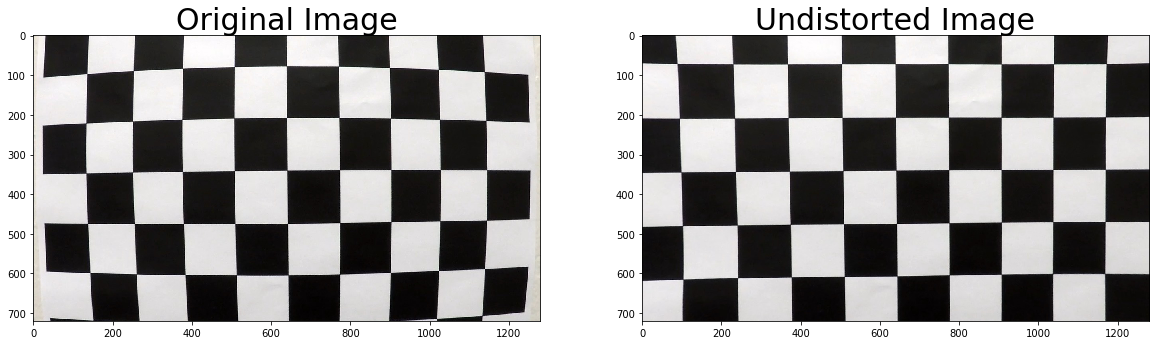

In [8]:
K = None
D = None

img = np.array(Image.open(imgPath+'calibration1.jpg'))

K, D, undistImg = calibAndUndist(img, objpoints, imgpoints)
mpimg.imsave('output_images/'+'undist_checkerboard.jpg', undistImg)

# Visualize undistortion
visualize(img, undistImg, 'Original Image', 'Undistorted Image')

In [9]:
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle['K'] = K
dist_pickle['D'] = D
pickle.dump( dist_pickle, open(imgPath+'intrinsics.p', "wb" ) )

## Pipeline (test images)

In [10]:
dist_pickle = pickle.load( open(imgPath+'intrinsics.p', "rb" ) )
K = dist_pickle['K']
D = dist_pickle['D']

### Distortion correction

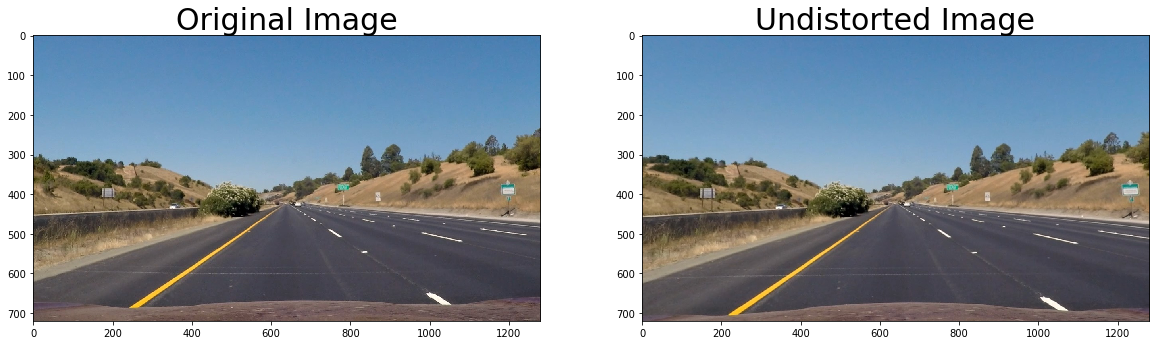

In [307]:
img = np.array(Image.open('test_images/straight_lines1.jpg'))
undistImg = distortionCorrection(img, K, D)
mpimg.imsave('output_images/'+'undist_test.jpg', undistImg)
# Visualize undistortion
visualize(img, undistImg, 'Original Image', 'Undistorted Image')

### Binary image

In [309]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gImg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelX = cv2.Sobel(gImg, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelY = cv2.Sobel(gImg, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dirGrad = np.arctan2(np.absolute(sobelY), np.absolute(sobelX))
    # 5) Create a binary mask where direction thresholds are met
    binary_output = cv2.inRange(dirGrad, thresh[0], thresh[1])
    binary_output[binary_output>0] = 1 # Hack for Udacity grader
    # 6) Return this mask as your binary_output image
    return binary_output

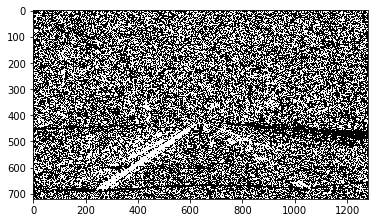

In [310]:
dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
plt.imshow(dir_binary, cmap='gray')

In [311]:
def binarize(img, s_thresh=(170, 255), sx_thresh=(40, 255), sobel_kernel=15, dir_thresh=(0.7, 1.3)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate L and S channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold gradient direction 
    dir_binary = dir_threshold(img, sobel_kernel, dir_thresh)
    
    # Stack each channel
    binary = np.zeros_like(s_channel)
    binary[((sxbinary>0) | (s_binary>0)) & (dir_binary > 0)] = 1
    color_binary = np.dstack((binary, binary, binary)) * 255
    return color_binary

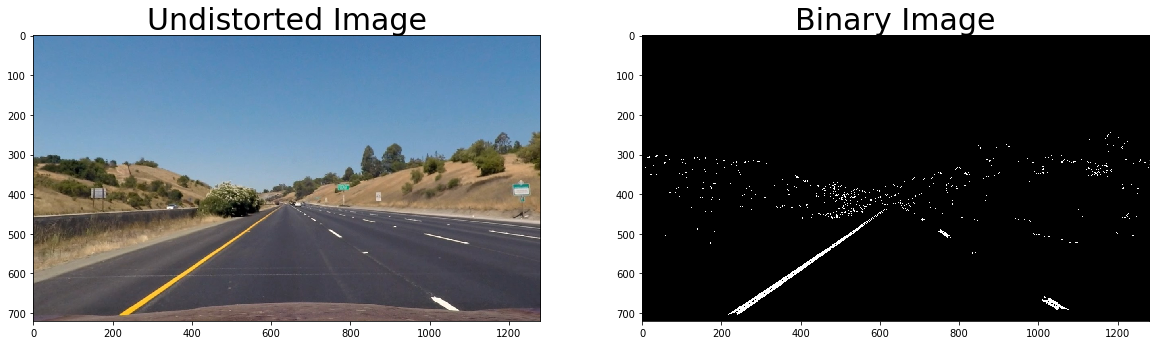

In [312]:
binaryImg = binarize(undistImg)

visualize(undistImg, binaryImg, 'Undistorted Image', 'Binary Image')
mpimg.imsave('output_images/'+'binary_test.jpg', binaryImg)

### Perspective transform

In [313]:
src = np.float32([[594.7,448.5], [684.8,448.5], [1074.95,692.3], [230.6,692.3]])
dst = np.float32([[360.6,0],[944.95,0],[944.95,720],[360.6,720]])

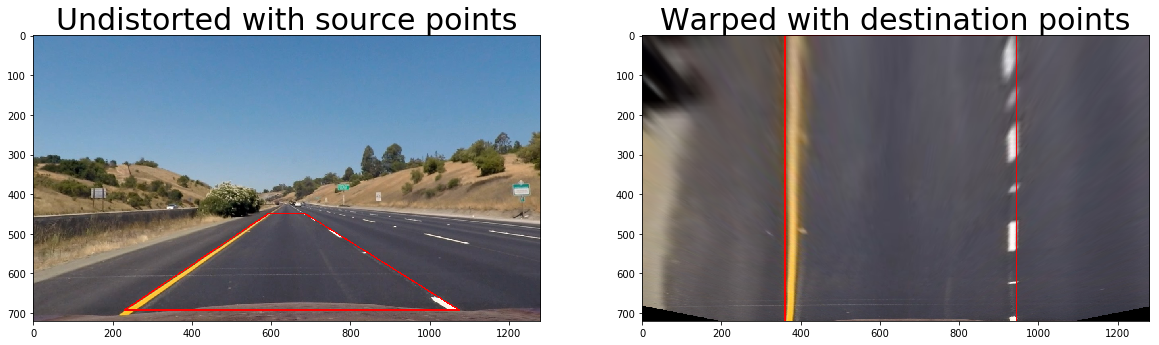

In [318]:
undistImgWTrap = undistImg.copy()
for i in range(4):
    cv2.line(undistImgWTrap, tuple(src[i]), tuple(src[(i+1)%4]), (255,0,0), 2)

M = cv2.getPerspectiveTransform(src, dst)
warpedImgColor = cv2.warpPerspective(undistImg, M, binaryImg.shape[1::-1], flags = cv2.INTER_LINEAR)

warpedImgRect = warpedImgColor.copy()
for i in range(4):
    cv2.line(warpedImgRect, tuple(dst[i]), tuple(dst[(i+1)%4]), (255,0,0), 2)

visualize(undistImgWTrap, warpedImgRect, 'Undistorted with source points', 'Warped with destination points')

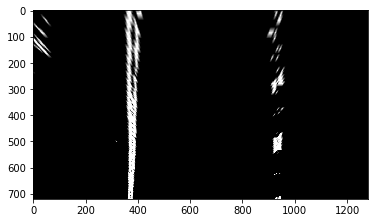

In [319]:
warpedImg = cv2.warpPerspective(binaryImg, M, binaryImg.shape[1::-1], flags = cv2.INTER_LINEAR)
plt.imshow(warpedImg)

### Identify lane line pixels

In [320]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low), 
                      (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low), 
                      (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [321]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img_rect = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    except:
        left_fit = [1, 1, 1]
        right_fit = [1, 1, 1]

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty


    out_img = np.zeros_like(out_img_rect)
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

#     # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fitx, right_fitx, out_img_rect

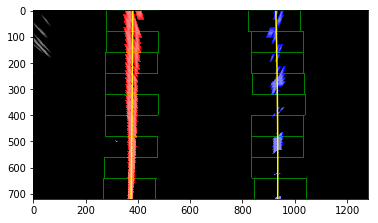

In [322]:
grayWarpedImg = cv2.cvtColor(warpedImg, cv2.COLOR_RGB2GRAY)
warpedLaneImg, left_fitx, right_fitx, rect_img = fit_polynomial(grayWarpedImg)

ploty = np.linspace(0, grayWarpedImg.shape[0]-1, grayWarpedImg.shape[0] )
# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

plt.imshow(cv2.addWeighted(warpedLaneImg, 1, rect_img, 0.5, 0))

### Measure curvature and offset from the center

In [323]:
def measure_curvature_real(binary_warped):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    y_eval = binary_warped.shape[0]-1
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 28/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/584 # meters per pixel in x dimension
    
    try:
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    except:
        left_fit_cr = [1, 1, 1]
        right_fit_cr = [1, 1, 1]

    
    ##### Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5)/np.abs(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5)/np.abs(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [324]:
# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real(grayWarpedImg)

xm_per_pix = 3.7/584 # meters per pixel in x dimension
offset = (right_fitx[grayWarpedImg.shape[0]-1] + left_fitx[grayWarpedImg.shape[0]-1])/2.0 - grayWarpedImg.shape[1]/2.0
offset_m = offset * xm_per_pix

print('Curvature radiuses are {:.2f}m and {:.2f}m for left and right lines respectively.'.format(left_curverad, right_curverad))
print('The car is {:.2f}m off the lane center'.format(offset_m))

Curvature radiuses are 27870.15m and 5915.37m for left and right lines respectively.
The car is 0.09m off the lane center


### Project lane lines on original image

In [325]:
Minv = cv2.getPerspectiveTransform(dst, src)

In [326]:
def projectBack(img, laneColorImg, left_fitx, right_fitx):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    
    # Create an image to draw the lines on
    color_warp = laneColorImg.copy()

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,128, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 1, 0)
    
    return result

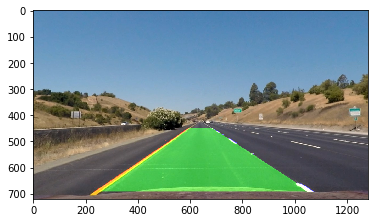

In [327]:
plt.imshow(projectBack(undistImg, warpedLaneImg, left_fitx, right_fitx))

### Full pipeline tested on all of the test images

In [278]:
def pipeline(img, K, D, M, Minv):
    undistImg = distortionCorrection(img, K, D)
    
    binaryImg = binarize(undistImg)
    
    warpedImg = cv2.warpPerspective(binaryImg, M, binaryImg.shape[1::-1], flags = cv2.INTER_LINEAR)
    
    grayWarpedImg = cv2.cvtColor(warpedImg, cv2.COLOR_RGB2GRAY)
    laneColorImg, left_fitx, right_fitx, _ = fit_polynomial(grayWarpedImg)
    left_curverad, right_curverad = measure_curvature_real(grayWarpedImg)
    
    xm_per_pix = 3.7/844 # meters per pixel in x dimension
    offset = (right_fitx[grayWarpedImg.shape[0]-1] + left_fitx[grayWarpedImg.shape[0]-1])/2.0 - grayWarpedImg.shape[1]/2.0
    offset_m = offset * xm_per_pix
    
    laneImg = projectBack(undistImg, laneColorImg, left_fitx, right_fitx)
    # TODO: add car position and lane curvature display + filtering
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    textColor = (255,255,255)
    cv2.putText(laneImg, 'Curvature is about {:.2f}m'.format((left_curverad + right_curverad)/2), (30,60), font, 2, textColor, 3)
    cv2.putText(laneImg, 'Offset is about {:.2f}m'.format(offset_m), (30,130), font, 2, textColor, 3)

    return laneImg

In [279]:
testImgs = glob.glob('test_images/*.jpg')

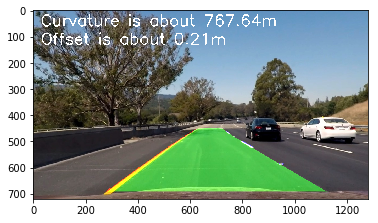

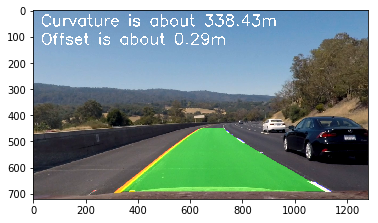

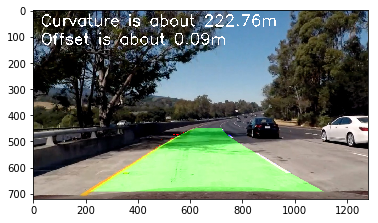

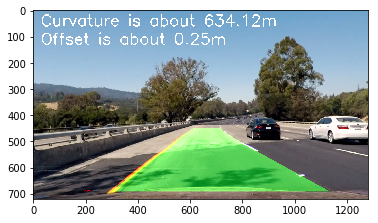

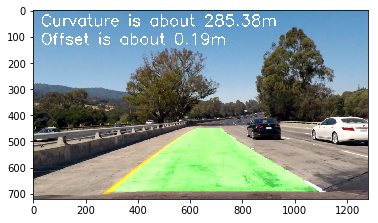

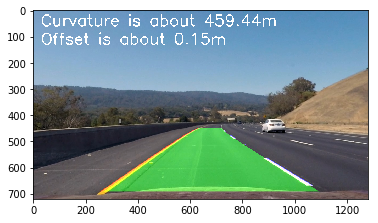

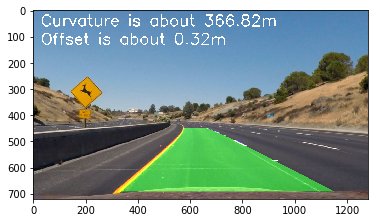

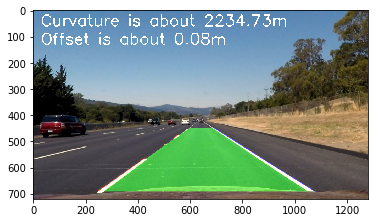

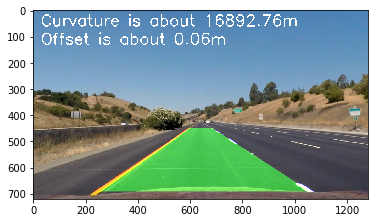

In [303]:
for imgPath in testImgs:
    img = np.array(Image.open(imgPath))[:,:,:3]
    plt.imshow(pipeline(img, K, D, M, Minv))
    plt.show()

## Test on videos

In [299]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [300]:
def process_image(image):
    return pipeline(image, K, D, M, Minv)

In [301]:
white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("harder_challenge_video.mp4").subclip(0,3)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4



100%|█████████▉| 1260/1261 [11:41<00:00,  1.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 7min 43s, sys: 1min 46s, total: 9min 30s
Wall time: 11min 44s


In [302]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))